<a href="https://colab.research.google.com/github/pipeton8/pattern-recognition/blob/main/assignments/1%20-%20Letter%20recognition/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Pattern Recognition

(c) Felipe del Canto, April 2021

---

# Classification between letters A, B, X, Y, Z

The objective is to designg a classifier that recognises each of the letter 'X', 'Y', 'Z', 'A' y 'B'.

There are 5 classes in this problem: 
  - Class 1 for the letter 'X'
  - Class 2 for the letter 'Y'
  - Class 3 for the letter 'Z'
  - Class 4 for the letter 'A'
  - Class 5 for the letter 'B'

# 0. Preamble

## Import libraries

In [ ]:
from   IPython.display import clear_output
import numpy as np

import scipy.ndimage as ndimage
import scipy.ndimage.interpolation as interpolation 
import scipy.ndimage.morphology as morphology

import matplotlib.pyplot as plt
import seaborn as sns


## Download images

Hay 100 imágenes por letra. 

- Las imágenes de la letra X están almacenadas en char_01_xxx.png

- Las imágenes de la letra Y están almacenadas en char_02_xxx.png

- Las imágenes de la letra Z están almacenadas en char_03_xxx.png

- Las imágenes de la letra A están almacenadas en char_04_xxx.png

- Las imágenes de la letra B están almacenadas en char_05_xxx.png

donde xxx = 001, 002, ..., 0100

In [ ]:
 # Descarga de todas las imágenes en la carpeta example
!wget 'https://drive.google.com/uc?export=download&id=1ACWetTZ7UGHfF3hmbUx1cRgc1FuPXq4G' -O 'letras.zip'
!unzip -o letras
clear_output()

In [ ]:
# Funciones necesarias para que se pueda cargar una imagen individual

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  # img = ImageLoad('example/char_',1,3)   loads image 'example/char_01_003.png'
  # img = ImageLoad('example/char_',2,15)  loads image 'example/char_02_015.png'
  st   = prefix + num2fixstr(num_char,2) + '_' + num2fixstr(num_img,3) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

loading image letras/char_01_075.png...


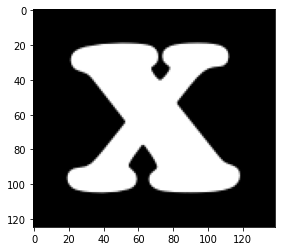

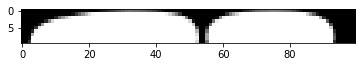

In [ ]:
# Lectura de una imagen X
fig    = plt.figure()
img    = ImageLoad('letras/char_',1,75,echo='on')
implot = plt.imshow(img,cmap='gray')

plt.figure()
img2 = cropLetter(img)
plt.imshow(img2[0:10,:],cmap='gray')

loading image letras/char_03_076.png...
(73, 58)


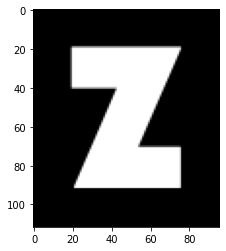

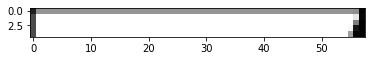

In [ ]:
# Lectura de una imagen Z
fig    = plt.figure()
img    = ImageLoad('letras/char_',3,76,echo='on')
implot = plt.imshow(img,cmap='gray')

plt.figure()
img2 = cropLetter(img)
print(img2.shape)
plt.imshow(img2[0:5,:],cmap='gray')

# 2. Extracción de Características

En este problema más complejo, donde las clases son múltiples y las letras tienen similitudes en una dimensión pero diferencias en otras, podríams plantear un clasificador que discrimine las clases en etapas. Para ello usaremos las siguientes características:

- **El área en pixeles de la letra (normalizada)**: Esta se mide luego de ser rellenados los agujeros. Este será un número entre 0 y 1, reflejando el porcentaje de pixeles que ocupa la letra.

- **El nivel de simetría especular (normalizada)**: Este se mide reflejando la imagen con respecto a un eje (puede ser horizontal o vertical) ubicado en el centro de la dimensión correspondiente. Luego, se restan las imágenes y se ve el porcentaje (D) que ocupa la diferencia. El nivel de simetría luego es S = 1-D y va entre 0 y 1.

- **Invarianza a rotación (normalizada)**: Esta se mide luego de rotar la imagen en 180º con respecto a su centro. Luego, se restan la imagen original con la modificada y se ve el porcentaje (D) que ocupa la diferencia. El nivel de simetría luego es S=1-D y va entre 0 y 1.

## Functions

### Image editing functions

In [ ]:
def cropLetter(img):
  imin,imax = np.nonzero(np.sum(img,axis=1))[0][[0,-1]]
  jmin,jmax = np.nonzero(np.sum(img,axis=0))[0][[0,-1]]

  return img[imin:imax+1,jmin:jmax+1] 

def squareImage(img):
  heightWidthDiff = img.shape[0] - img.shape[1]

  if heightWidthDiff == 0:
    return img

  elif heightWidthDiff > 0:  
    if heightWidthDiff % 2 == 0:
      indexToDrop = int(heightWidthDiff/2)

      return img[indexToDrop:-indexToDrop,:]
    
    else:
      indexToDrop = int((heightWidthDiff-1)/2)

      return img[indexToDrop:-(indexToDrop+1),:]
  
  else:
    if abs(heightWidthDiff) % 2 == 0:
      indexToDrop = int(abs(heightWidthDiff)/2)

      return img[:, indexToDrop:-indexToDrop]

    else:
      indexToDrop = int((abs(heightWidthDiff)-1)/2)

      return img[:, indexToDrop:-(indexToDrop+1)]

def StandarizeImage(img, iterations=2):
  if iterations > 0:
    R = morphology.binary_dilation(img>0.5, iterations=iterations) # Segmentada y dilatada
  
  else: 
    R = (img>0.5)

  Rfill = morphology.binary_fill_holes(R).astype(int) # imagen con relleno de agujeros

  return Rfill,R

### Characteristics extraction functions

In [ ]:
def centerOfMass(img,crop=False,normalized=False,echo='off'):
  R = (img>0.5).astype(int) # segmentación
  
  if crop:
    R = cropLetter(R)

  CM = []

  for axis in [1,0]:
    distr = np.sum(R,axis=axis)
    distr = distr/np.sum(distr)
    CMcoordinate = np.dot(distr,[i for i in range(np.size(distr))])
    
    if normalized:
      CMcoordinate = CMcoordinate/(np.size(distr)-1)
    else:
      CMcoordinate = int(CMcoordinate)

    CM.append(CMcoordinate)

  return CM

def area(img, hdiv=1, vdiv=1, normalized=True,crop=False, echo='off'):
  if crop:
    img = cropLetter(img)

  if hdiv+vdiv > 2:
    areaVector = np.zeros((vdiv,hdiv))

    for i in range(vdiv):
      for j in range(hdiv):
        rowBatch = np.floor(img.shape[0]/vdiv).astype(int)
        columnBatch = np.floor(img.shape[1]/hdiv).astype(int)

        subImage = img[rowBatch*i:rowBatch*(i+1), columnBatch*j: columnBatch*(j+1)]

        areaVector[i,j] = area(subImage, echo=echo)

    areaVector = areaVector.flatten()

    if normalized:
      return areaVector/np.linalg.norm(areaVector)
    
    else:
      return areaVector

  # Dilatación y rellenado de agujeros
  R,_ = StandarizeImage(img)
  
  # Cálculo de área
  CharArea = np.sum(R)                 # area de la letra en pixeles
  ImgArea  = np.size(R)                # numero de pixeles de la imagen
  AreaN = CharArea/ImgArea             # area normalizada

  if echo=='on':
    plt.figure()
    implot = plt.imshow(R,cmap='gray') 
    print('Area normalizada = {}'.format(AreaN))

  return AreaN

def AgujerosNormalizado(img, crop = False, iterations=2, echo='off'):
  if crop:
    img = cropLetter(img)

  # Dilatación y rellenado de agujeros
  Rfill,R = StandarizeImage(img,iterations)

  DiffImage = Rfill - R # matriz que tiene un 1 donde están los agujeros

  # Calcular área normalizada de los agujeros
  HoleArea = np.sum(DiffImage)
  ImageArea = np.size(R)
  NormalizedHoles = HoleArea/ImageArea

  if echo=='on':
    plt.figure()
    implot = plt.imshow((R+Rfill==1),cmap='gray') 

    print('Área normalizada de los agujeros = {}'. format(NormalizedHoles))

  return NormalizedHoles

def clasificarCentroMasaAgujeros(img):
  Rfill,R = StandarizeImage(img)

  DiffImage = Rfill - R # matriz que tiene un 1 donde están los agujeros

  if np.sum((DiffImage)) == 0:
    return 0

  # Centro de masa de la imagen con agujeros
  CM = centerOfMass(DiffImage, normalized=False)

  if DiffImage[CM[0],CM[1]] == 1:
    return 1
  else:
    return 0

def tracesSize(img, iterations=10):
  R = cropLetter(img>0.5)
  
  if iterations > 0:
    R = morphology.binary_erosion(R,iterations=iterations).astype(int)

  traceNormalized = np.trace(R)/R.shape[0]
  reverseTraceNormalized = np.trace(np.fliplr(R))/R.shape[0]

  traceVector = np.array((traceNormalized, reverseTraceNormalized))

  if np.sum(traceVector) == 0:
    return traceVector

  return traceVector/np.linalg.norm(traceVector)

def rotationConformability(img):
  R = squareImage(cropLetter(img>0.5)).astype(int)

  rotatedImages = [ndimage.rotate(R,angle=angle) for angle in [90,180,270]]
  
  areaVector = [np.sum(rotatedImages[i]+R == 2)/np.sum(R) for i in range(3)]
  areaVector = np.array(areaVector)  

  return areaVector

def identifyCentralHole(img, initialPixel = 0, pixelWindow = 5, maskSize = 15, maskPadding = 5, mode = 'horizontal'):
  img = cropLetter(img)
  
  if mode == 'horizontal':
    imgWindow = img[initialPixel:(initialPixel+pixelWindow), :]

  elif mode == 'vertical':
    imgWindow = img[:, initialPixel:(initialPixel+pixelWindow)].T
  
  else:
    raise ValueError("Mode not implemented")

  collapsedWindow = np.sum(imgWindow,axis=0)

  if maskSize == 0:
    mask1 = np.concatenate((np.ones(collapsedWindow.size//3),
                           np.zeros(collapsedWindow.size//3),
                           np.ones(collapsedWindow.size//3)))

    if mask1.size < collapsedWindow.size:
      mask1 = np.concatenate((mask1, np.ones(collapsedWindow.size-mask1.size)))

    mask2 = (mask1==0).astype(int)

  else:
    mask1 = np.concatenate((np.zeros(maskPadding),
                          np.ones(maskSize),
                          np.zeros(collapsedWindow.size-2*maskSize-2*maskPadding),
                          np.ones(maskSize),
                          np.zeros(maskPadding)))

    mask2 = np.concatenate((np.zeros((collapsedWindow.size-maskSize)//2),
                           np.ones(maskSize),
                           np.zeros((collapsedWindow.size-maskSize)//2)))
    
    if mask2.size < collapsedWindow.size:
      mask2 = np.concatenate((np.zeros(collapsedWindow.size-mask2.size),mask2))

  masksProducts = [np.dot(collapsedWindow,mask1.T), np.dot(collapsedWindow,mask2.T)]
  
  if masksProducts[0]/2 > masksProducts[1]:
    return 1

  else:
    return 0

## Extraction

In [ ]:
# Extracción de la características características y separación entre test y training

K = 5       # número de clases
Ntrain = 75 # número de imágenes de entrenamiento por clase
Ntest  = 25 # número de imágenes de testeo por clase
Ncaract = 4 + 1 + 1 + 2 + 2 + 3 + 1*3 # número de características

Xtrain = np.zeros((K*Ntrain,Ncaract))
Xtest  = np.zeros((K*Ntest,Ncaract))

for j in range(K):     # para cada clase
  for i in range(Ntrain+Ntest):   # para cada imagen de la clase

    # Lectura de la imagen
    img    = ImageLoad('letras/char_',j+1,i+1,echo='off')

    # Extracción de características
    caract = np.array((*area(img,hdiv=2,vdiv=2, crop = True),
                      AgujerosNormalizado(img),
                      clasificarCentroMasaAgujeros(img),
                      *centerOfMass(img,normalized=True,crop=True),
                      *tracesSize(img, iterations=5),
                      *rotationConformability(img),
                      identifyCentralHole(img,pixelWindow=5,maskSize=15,maskPadding=5),
                      identifyCentralHole(img,pixelWindow=10,maskSize=15,maskPadding=5),
                      identifyCentralHole(img,pixelWindow=15,maskSize=15,maskPadding=5)))
    
    # Inputar en la matriz correspondiente
    if i < Ntrain:
      Xtrain[Ntrain*j+i,:] = caract
    else:
      Xtest[Ntest*j+i-Ntrain,:] = caract

XtrainX = Xtrain[0:75,:]
XtrainY = Xtrain[75:150,:]
XtrainZ = Xtrain[150:225,:]
XtrainA = Xtrain[225:300,:]
XtrainB = Xtrain[300:375,:]

## Visualization

### Tamaño de los agujeros y centro de masa

De las 5 letras diferentes, solo la A y la B poseen agujeros. Usando la función `AgujerosNormalizado`, podemos recuperar el área utilizada por los agujeros de cada imagen, luego de segmentarla y dilatarla (para que letras A que no están conectadas completamente sí lo estén.

En el histograma siguiente se puede verificar que las letras X, Y, Z quedan separadas de las letras A y B cuando se clasifican por esta característica. Sin embargo, algunas pocas letras X, Y, Z quedan con área de agujeros positiva producto de la dilatación.

Hay 7 letras (X, Y ó Z) que tienen área positiva de agujeros.
Hay 0 letras (A ó B) que tienen área 0 de agujeros.


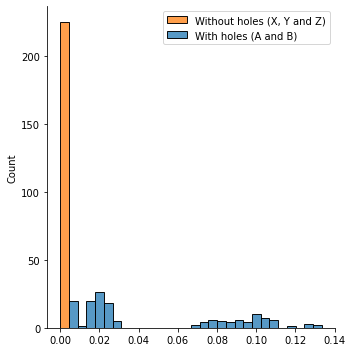

In [ ]:
holes = Xtrain[225:375,4]
noHoles = Xtrain[0:225,4]

sns.displot([holes,noHoles], bins=30, legend=False)
plt.legend(["Without holes (X, Y and Z)","With holes (A and B)"])

print("Hay {} letras (X, Y ó Z) que tienen área positiva de agujeros.".format(np.sum(noHoles>0)))
print("Hay {} letras (A ó B) que tienen área 0 de agujeros.".format(np.sum(holes==0)))

holesThreshold = 0

Además, cuando clasificamos las imágenes de acuerdo a la posición del centro de masa de el o los agujeros, podemos diferenciar la A de la B. Esto porque típicamente el centro de masa de los agujeros de B está fuera de ellos, mientras que el centro de masa del agujero de A debería estar dentro.

A vs B hole area threshold = 0.05


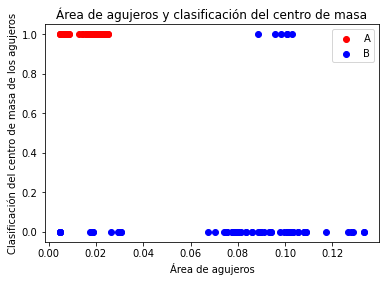

In [ ]:
plt.figure()
plt.scatter(XtrainA[:,4],XtrainA[:,5], c = 'red')
plt.scatter(XtrainB[:,4],XtrainB[:,5], c = 'blue')
plt.title("Área de agujeros y clasificación del centro de masa")
plt.xlabel("Área de agujeros")
plt.ylabel("Clasificación del centro de masa de los agujeros")
plt.legend(["A", "B"])

holeAreaABThreshold = (np.mean(XtrainA[:,4]) + np.mean(XtrainB[:,4]))/2
print("A vs B hole area threshold = {:.2f}".format(holeAreaABThreshold))

### Centro de masa, coordenada vertical



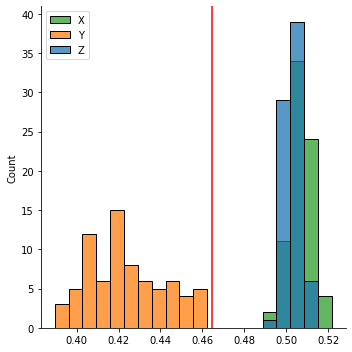

In [ ]:
sns.displot([XtrainX[:,6],XtrainY[:,6],XtrainZ[:,6]],bins=20,legend=False)
plt.legend(["X", "Y","Z"])

CMthreshold = (np.mean(np.concatenate([XtrainX[:,6],XtrainZ[:,6]])) + np.mean(XtrainY[:,6]))/2
plt.axvline(x=CMthreshold, color = 'red')


### Traces saturation



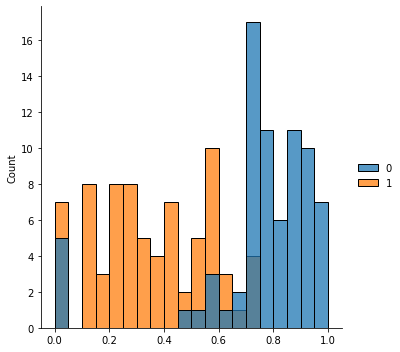

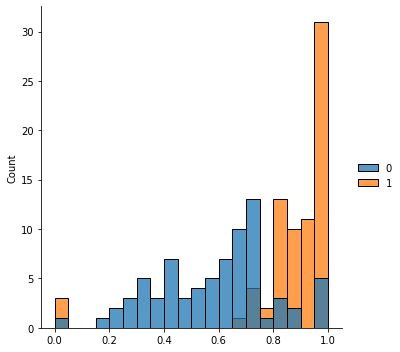

In [ ]:
sns.displot([XtrainX[:,8], XtrainZ[:,8]],bins=20,legend=True)
sns.displot([XtrainX[:,9], XtrainZ[:,9]],bins=20,legend=True)

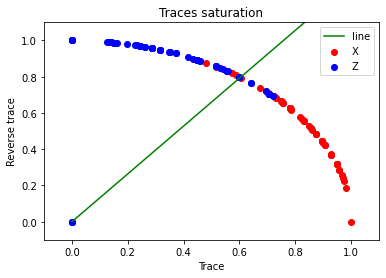

In [ ]:
plt.figure()
plt.scatter(XtrainX[:,8],XtrainX[:,9], c = 'red')
plt.scatter(XtrainZ[:,8],XtrainZ[:,9], c = 'blue')

thresholdTrace = (np.mean(XtrainX[:,8]) + np.mean(XtrainZ[:,8]))/2
reverseThresholdTrace = (np.mean(XtrainX[:,9]) + np.mean(XtrainZ[:,9]))/2

#plt.plot([0,1], [reverseThresholdTrace,reverseThresholdTrace], c = 'green')
#plt.plot([thresholdTrace,thresholdTrace], [0,1], c = 'green')

plt.plot([0,1],[0,reverseThresholdTrace/thresholdTrace], c = 'green',clip_on = True)
plt.title("Traces saturation")
plt.xlabel("Trace")
plt.ylabel("Reverse trace")
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.legend(["line", "X", "Z", ])

### Subimage area

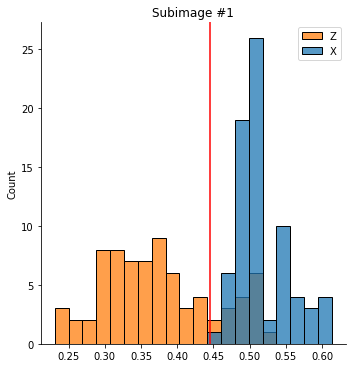

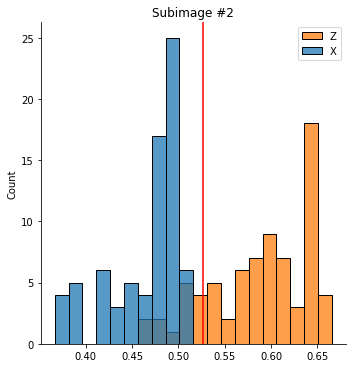

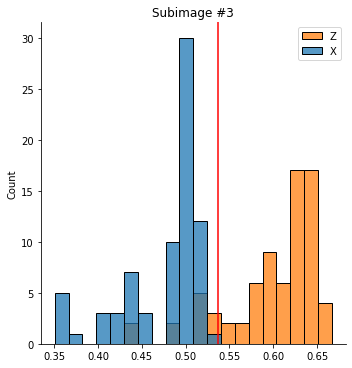

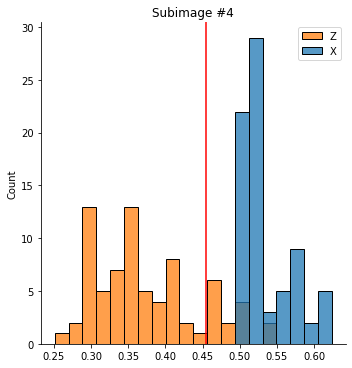

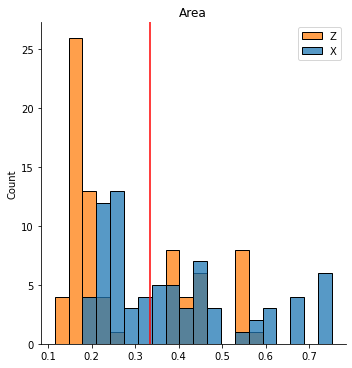

In [ ]:
subImageThresholds = []

for i in range(4):
  sns.displot([XtrainX[:,i], XtrainZ[:,i]],bins=20,legend=False)
  plt.title("Subimage #{:d}".format(i+1))
  plt.legend(["Z", "X"])

  subImageThreshold = (np.mean(XtrainX[:,i]) + np.mean(XtrainZ[:,i]))/2
  subImageThresholds.append(subImageThreshold)

  plt.axvline(x=subImageThreshold, color = 'red')

sns.displot([XtrainX[:,10], XtrainZ[:,10]],bins=20,legend=False)
plt.title("Area")
plt.legend(["Z", "X"])

subImageThreshold = (np.mean(XtrainX[:,10]) + np.mean(XtrainZ[:,10]))/2
subImageThresholds.append(subImageThreshold)

plt.axvline(x=subImageThreshold, color = 'red')


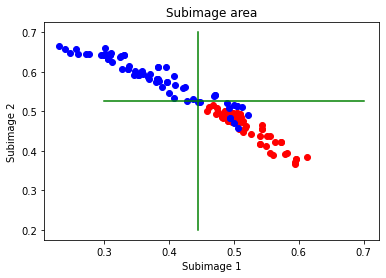

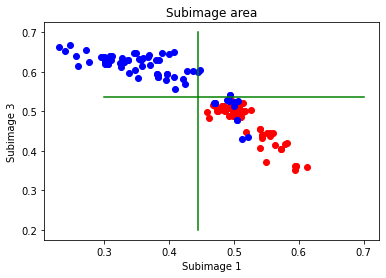

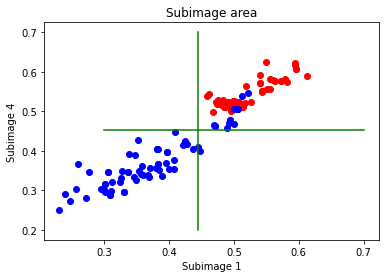

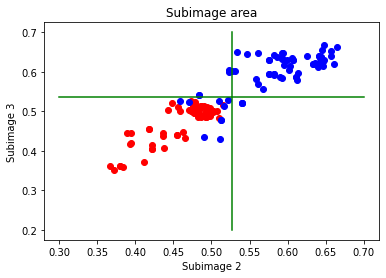

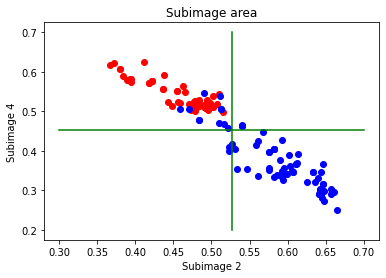

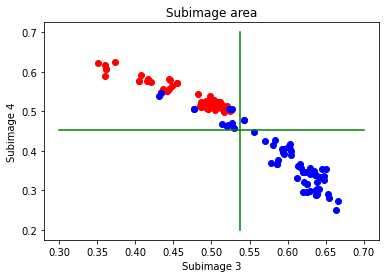

In [ ]:
for i in range(3):
  for j in range(i+1,4):
    plt.figure()
    plt.scatter(XtrainX[:,i],XtrainX[:,j], c = 'red')
    plt.scatter(XtrainZ[:,i],XtrainZ[:,j], c = 'blue')

    plt.plot([subImageThresholds[i],subImageThresholds[i]],[0.2,0.7], c = 'green',clip_on = True)
    plt.plot([0.3,0.7], [subImageThresholds[j],subImageThresholds[j]], c = 'green',clip_on = True)

    plt.title("Subimage area")
    plt.xlabel("Subimage {:d}".format(i+1))
    plt.ylabel("Subimage {:d}".format(j+1))
    #plt.xlim([-0.1,1.1])
    #plt.ylim([-0.1,1.1]) 

### Rotation conformability

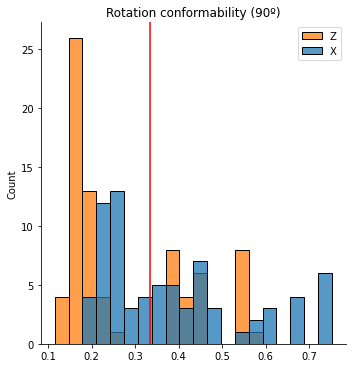

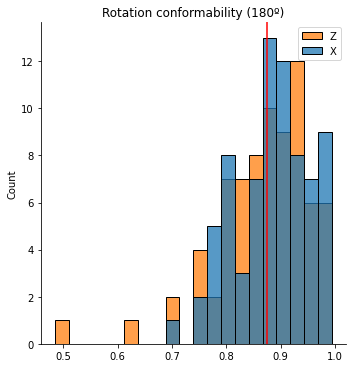

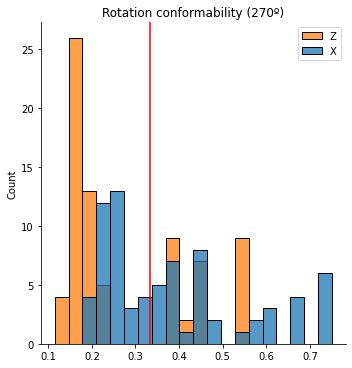

In [ ]:
rotationThresholds = []

for i in range(3):
  sns.displot([XtrainX[:,i+10], XtrainZ[:,i+10]],bins=20,legend=False)
  plt.title("Rotation conformability ({:d}º)".format(90*(i+1)))
  plt.legend(["Z", "X"])

  rotationThreshold = (np.mean(XtrainX[:,i+10]) + np.mean(XtrainZ[:,i+10]))/2
  rotationThresholds.append(rotationThreshold)

  plt.axvline(x=rotationThreshold, color = 'red')


### Above area

Text(0, 0.5, 'Below Area')

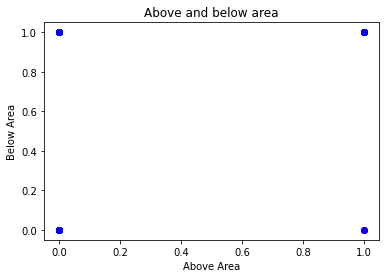

In [ ]:
plt.figure()
plt.scatter(XtrainX[:,13],XtrainX[:,14], c = 'red')
plt.scatter(XtrainZ[:,13],XtrainZ[:,14], c = 'blue')

plt.title("Above and below area")
plt.xlabel("Above Area")
plt.ylabel("Below Area")

### Hole in the center

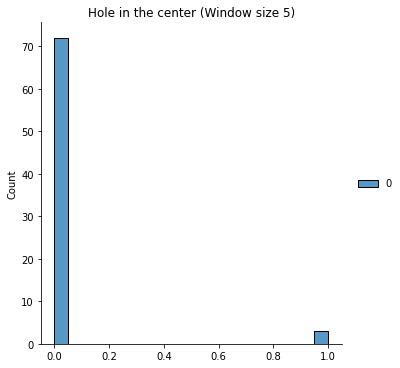

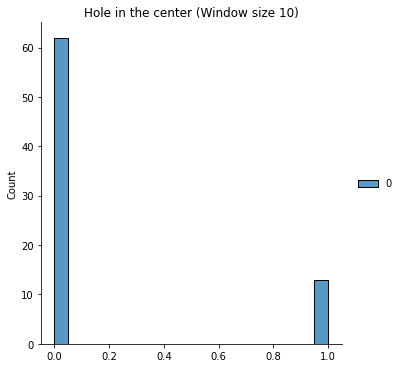

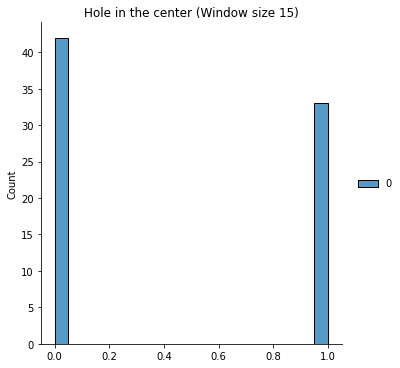

In [ ]:
windowSizes = [5,10,15]

for i in range(13,16):
  sns.displot([XtrainB[:,i]], bins=20, legend=True)
  plt.title("Hole in the center (Window size {:d})".format(windowSizes[i-13]))

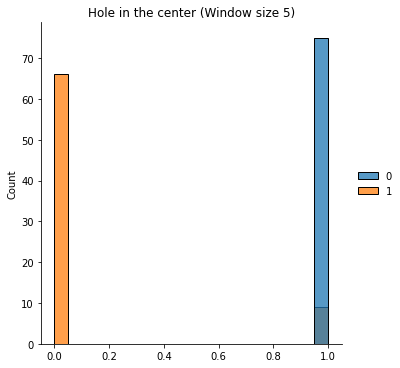

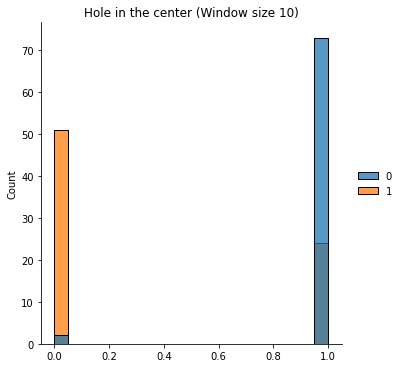

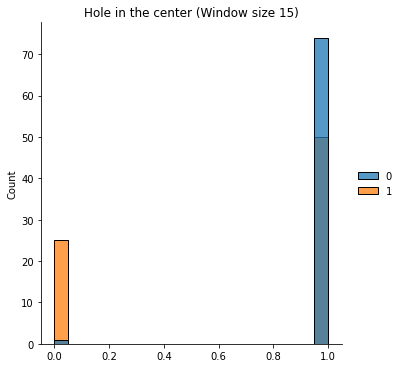

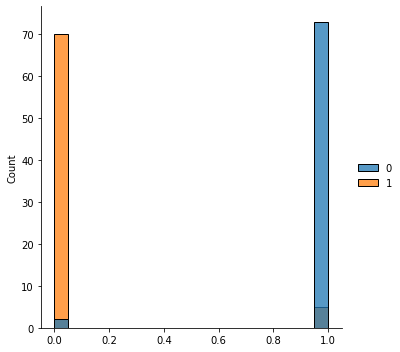

In [ ]:
windowSizes = [5,10,15]

for i in range(13,16):
  sns.displot([XtrainX[:,i], XtrainZ[:,i]], bins=20, legend=True)
  plt.title("Hole in the center (Window size {:d})".format(windowSizes[i-13]))

XtrainXcenterHoles = (np.sum(XtrainX[:,[13,14,15]],axis=1)>2).astype(int)
XtrainZcenterHoles = (np.sum(XtrainZ[:,[13,14,15]],axis=1)>2).astype(int)

sns.displot([XtrainXcenterHoles,XtrainZcenterHoles], bins=20, legend=True)

# 3. Clasificación

In [ ]:
def classifyImage(X, holeAreaABThreshold, CMthreshold, thresholdTrace, reverseThresholdTrace, subImageThresholds, holeAreaThreshold = 0):
  # First, decide if image is A/B (positive hole area) or X/Y/Z (0 hole area)
  if X[4] > holeAreaThreshold and np.sum(X[13:16]) != 3:

    # B's have a bigger hole area in general
    if X[4] > holeAreaABThreshold:
      return 5

    # Some B's have small hole area, but the center of mass of the holes does
    # not belong to them
    elif X[4] <= holeAreaABThreshold and X[5] == 0:
      return 5
    
    # A's have their hole center of mass inside the hole
    elif X[5] == 1:
      return 4
    
    # These decision cover all posibilities

  else:
   # Y's have the vertical (row) coordinate of their center of mass slightly
   # above in the image, that is, closer to 0.
   if X[6] < CMthreshold:
     return 2
    
   # In order to differentiate X's from Z's we use a majority voting system
   # based on the area of the 4 quadrants of the image  
   elif np.sum(X[13:16]) == 3:
     return 1
    
   else:
     return 3

In [ ]:
# Ground truth
Y = np.zeros(Ntest*K)

for i in range(K):
  Y[Ntest*i:Ntest*(i+1)] = i+1

Y = Y.astype(int)

In [ ]:
# Clasificación del conjunto de testing
Ypred = np.zeros(Ntest*K)

for i in range(Ntest*K):
  Ypred[i] = classifyImage(Xtest[i], holeAreaABThreshold, CMthreshold, thresholdTrace, reverseThresholdTrace, subImageThresholds)

Ypred = Ypred.astype(int)

# 4. Evaluación

In [ ]:
# Evaluación del conjunto Testing
MC = np.zeros((K,K))

for i in range(Ntest*K):
  MC[Y[i]-1,Ypred[i]-1] += 1


print("    X  Y  Z  A  B")
for i in range(K):
  letras = ["X", "Y", "Z", "A", "B"]

  print(letras[i], end=' ')
  print(MC[i,:].astype(int))

# Accuracy (% de aciertos)
Acc = np.trace(MC)/np.sum(MC)*100

print('\n Accuracy = {:.2f}%'.format(Acc))

    X  Y  Z  A  B
X [23  0  1  1  0]
Y [ 0 25  0  0  0]
Z [ 0  0 24  1  0]
A [ 0  0  0 25  0]
B [ 0  0  0  0 25]

 Accuracy = 97.60%
